# Train Image Classifier with k-Fold Cross Validation

## Import Libraries

In [1]:
import sys
print(sys.path)

import os
from datetime import datetime
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import PIL
import pydot
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
#from torchvision import transforms, utils, datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchdiffeq import odeint_adjoint as odeint
#tf.config.list_physical_devices('GPU')

['/data/rover/defect_inspector/src', '/opt/caffe/python', '/data/rover/defect_inspector/src', '/data/rover/.conda/envs/torch_test/lib/python37.zip', '/data/rover/.conda/envs/torch_test/lib/python3.7', '/data/rover/.conda/envs/torch_test/lib/python3.7/lib-dynload', '', '/data/rover/.conda/envs/torch_test/lib/python3.7/site-packages', '/data/rover/.conda/envs/torch_test/lib/python3.7/site-packages/IPython/extensions', '/home/rover/.ipython']


In [2]:
import torch
print(torch.cuda.is_available())
#print(torch.cuda.device())

True


## Predifined Variables

In [2]:
current_dir = os.path.dirname(os.path.abspath(''))

DATASET_PATH = os.path.join('/data/datasets/bamboo_skewers/labeled/20201023.production/cropped/3types')
FEATURE_IMG_PATH = os.path.join('/data/datasets/bamboo_skewers/labeled/20200817.production/cropped/s05')
print('Dataset: {}'.format(os.path.abspath(DATASET_PATH)))

INPUT_HEIGHT = 200
INPUT_WIDTH = 1750
INPUT_CHANNEL = 3
TARGET_SIZE = (INPUT_HEIGHT, INPUT_WIDTH)
#TARGET_SIZE = (INPUT_HEIGHT, INPUT_WIDTH,INPUT_CHANNEL)
COLORMODE = 'rgb' # Options: 'grayscale', 'rbg'

BATCH_SIZE = 64
STEPS_PER_EPOCH_RATIO = 3
EPOCH_END = 200
EARLY_STOPPING_PATIENCE = 24
LEARNING_RATE_BEGIN = 1e-3
K_FOLD_NUM = 4
RUN_FIRST_FOLD_ONLY_FOR_TESTING = True
TEST_SIZE_RATIO = 0.2

#CLASSES = ['ng', 'ok']
CLASSES = ['dirty','ok','serious']
CHANNEL = 1 if COLORMODE == 'grayscale' else 3
input_shape = (INPUT_HEIGHT, INPUT_WIDTH, CHANNEL)
num_classes = len(CLASSES)

# Data normalization
featurewise_center = False

# Data augmentation
height_shift_range = 0.1 # randomly shift images vertically (fraction of total height)
width_shift_range = 0.1 # randomly shift images horizontally (fraction of total width)
rotation_range = 3
brightness_range = (0.8, 1.2)
zoom_range = (0.9, 1.1)
vertical_flip = 0
horizontal_flip = 0

preprocess_num,mask_num,trunk_num = 1, 1, 2
bn_axis = 3
tol = 1e-5
MAX_NUM_STEPS = 1000
Base = 'pytorch'
Net = 'ODENet'
TRAINING_NOTES = '{}-{}-{}-{}'.format(Base,Net,-1*int(np.log10(tol)),'ODEOnly_3types')

Dataset: /data/datasets/bamboo_skewers/labeled/20201023.production/cropped/3types


## Load Images

In [3]:
train_transform = transforms.Compose([transforms.RandomAffine(degrees=rotation_range, translate=(width_shift_range,height_shift_range), scale=zoom_range, shear=None, resample=0, fillcolor=0),
                                     transforms.ColorJitter(brightness=brightness_range, contrast=0, saturation=0, hue=0),
                                     transforms.RandomVerticalFlip(p=vertical_flip),
                                     transforms.RandomHorizontalFlip(p=horizontal_flip),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToTensor()])
                                    #transforms.Normalize((0,0,0),(255,255,255))])
test_dataset = datasets.ImageFolder(DATASET_PATH, transform=test_transform)
#No Normalization

## Visualize Training Samples

Display samples: 8 x 8


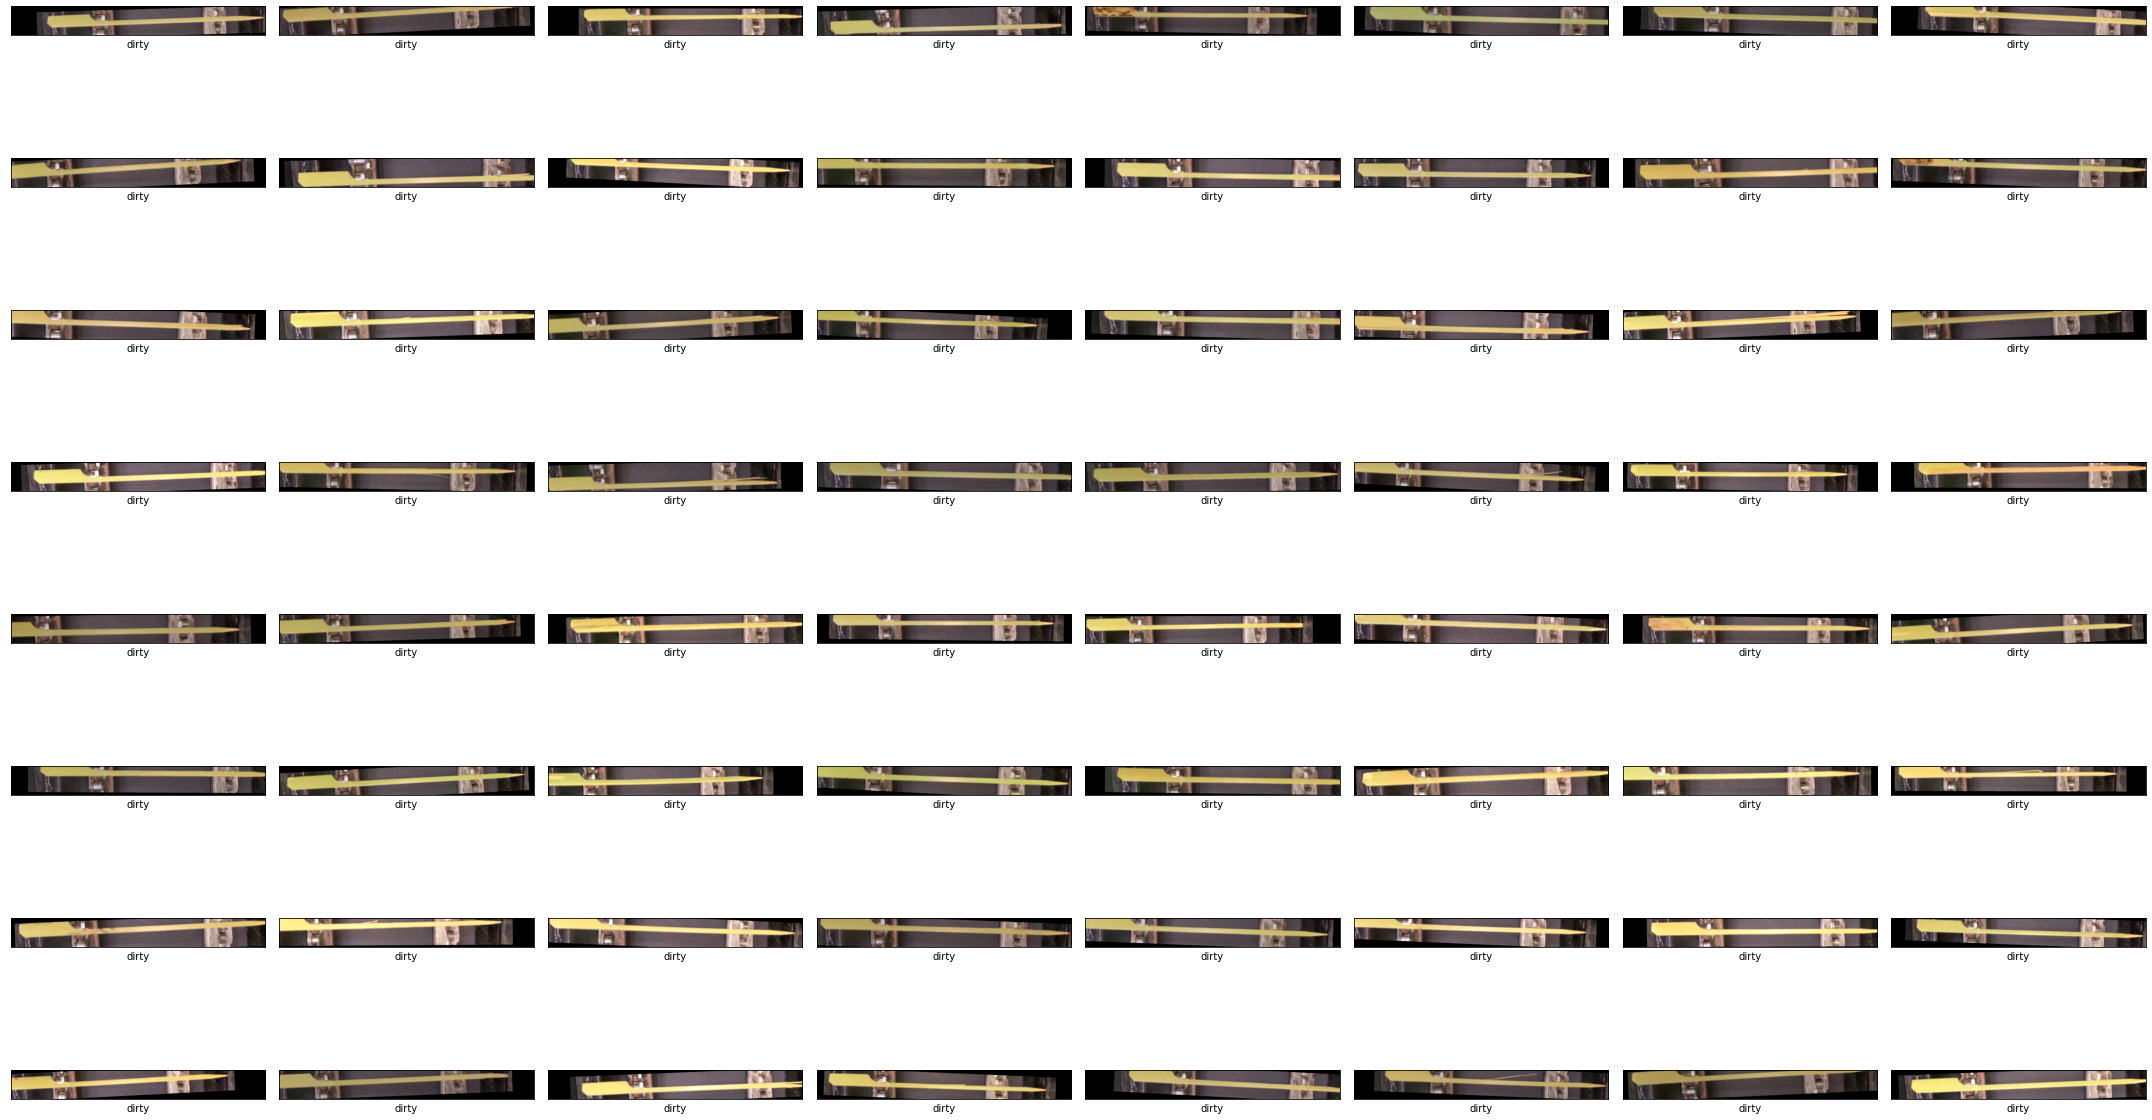

In [4]:
dataset = datasets.ImageFolder(DATASET_PATH, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
images, labels = next(iter(dataloader))

n_col = n_row = np.ceil(np.sqrt(len(labels))).astype(int)
print('Display samples: {} x {}'.format(n_row, n_col))
fig = plt.figure(figsize=(30, 18))
for i, img in enumerate(images):
    #img = img.reshape(TARGET_SIZE)
    plt.subplot(n_row, n_col, 1+i)
    plt.xlabel(CLASSES[np.argmax(labels[i])])
    plt.xticks([])
    plt.yticks([])
    #plt.imshow(img, cmap='gray')
    plt.imshow(np.asarray(img).transpose((1,2,0)))
plt.tight_layout()
plt.show()

## Build & Compile Model

In [5]:
def convkxk(in_planes, out_planes, stride=1, kernel_size=3, padding= 1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size, stride=stride, padding = padding, bias=True)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True)


def norm(dim):
    return nn.BatchNorm2d(dim)


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [6]:
class Preactivate_Conv(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1):
        super(Preactivate_Conv, self).__init__()
        self.inplanes = inplanes
        self.bn = nn.BatchNorm2d(inplanes,eps=1e-04, momentum=0.01)
        self.relu = torch.relu
        if  kernel_size!=1:
            self.conv1 = convkxk(inplanes, planes, stride, kernel_size, padding = int((kernel_size-1)/2))
        else:
            self.conv1 = conv1x1(inplanes, planes, stride)
    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv1(out)
        return out

class Conv_Block(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, strides=2):
        super(Conv_Block, self).__init__()
        self.preactivate_conv_1_s = Preactivate_Conv(inplanes, planes, 1, strides)
        self.preactivate_conv_k_1 = Preactivate_Conv(planes, planes, kernel_size, 1)
        self.preactivate_conv_1_1_4 = Preactivate_Conv(planes, planes*4, 1, 1)
        self.preactivate_conv_1_s_4 = Preactivate_Conv(inplanes, planes*4, 1, strides)
        self.inplanes = inplanes
        self.planes = planes
        self.strides = strides
        self.kernel_size = kernel_size

    def forward(self, x):
        input_tensor = x
        out = self.preactivate_conv_1_s(x)
        out = self.preactivate_conv_k_1(out)
        out = self.preactivate_conv_1_1_4(out)
        x_shortcut = self.preactivate_conv_1_s_4(input_tensor)
        return out + x_shortcut

class Residual_Unit(nn.Module):
    def __init__(self, filters, stride_num):
        super(Residual_Unit, self).__init__()
        self.preactivate_conv1 = Preactivate_Conv(filters*4, filters, 1, 1)
        self.preactivate_conv2 = Preactivate_Conv(filters, filters, 3, stride_num)
        self.preactivate_conv3 = Preactivate_Conv(filters, filters*4, 1, 1)

    def forward(self, x):
        input_tensor = x
        out = self.preactivate_conv1(x)
        out = self.preactivate_conv2(out)
        out = self.preactivate_conv3(out)
        return out + input_tensor

def maxpooling2d(dim=2):
    return nn.MaxPool2d(dim,dim)

def upsampling(size):
    return nn.UpsamplingBilinear2d(size)
    
class Mask_Unit(nn.Module):
    def __init__(self, residual_unit, filters, stride_num, residual_unit_num):
        super(Mask_Unit, self).__init__()
        self.residual_unit = residual_unit(filters, stride_num)
        self.maxpooling2d = maxpooling2d(2)
        self.residual_unit_num = residual_unit_num
        self.upsampling = upsampling
        self.conv1_1 = conv1x1(filters*4, filters*4, 1)
        self.conv1_2 = conv1x1(filters*4, filters*4, 1)
        self.sigmoid = torch.sigmoid
        self.residual_loop_1 = self._residual_unit_loop(residual_unit, residual_unit_num, filters, stride_num, 1)
        self.residual_loop_2 = self._residual_unit_loop(residual_unit, residual_unit_num, filters, stride_num, 2)
        self.residual_loop_3 = self._residual_unit_loop(residual_unit, residual_unit_num, filters, stride_num, 1)
    
    def _residual_unit_loop(self, residual_unit, residual_unit_num, filters, stride_num, times):
        layers = []
        for i in range(residual_unit_num):
            for j in range(times):
                layers.append(residual_unit(filters, stride_num))
        return nn.Sequential(*layers)

    def forward(self, x):
        first_shape = (x.shape[2],x.shape[3])
        x = self.maxpooling2d(x)
        second_shape = (x.shape[2],x.shape[3])
        x = self.residual_loop_1(x)
        x_shortcut = x
        x = self.maxpooling2d(x)
        x = self.residual_loop_2(x)
        x = self.upsampling(second_shape)(x)
        x = x+self.residual_unit(x_shortcut)
        x = self.residual_loop_3(x)
        x = self.upsampling(first_shape)(x)
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.sigmoid(x)
        return x
    
class Trunk_Unit(nn.Module):
    def __init__(self, residual_unit, filters, stride_num, trunk_num):
        super(Trunk_Unit, self).__init__()
        self.residual_loop = self._residual_unit_loop(residual_unit, trunk_num, filters, stride_num)
        
    def _residual_unit_loop(self, residual_unit, trunk_num, filters, stride_num):
        layers = []
        for i in range(trunk_num):
            layers.append(residual_unit(filters, stride_num))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.residual_loop(x)
        return x

class Attention_Module(nn.Module):
    def __init__(self, residual_unit, mask_unit, trunk_unit, filters, stride_num, preprocess_num, mask_num, trunk_num):
        super(Attention_Module, self).__init__()
        self.mask_unit = mask_unit(residual_unit, filters, stride_num, mask_num)
        self.trunk_unit = trunk_unit(residual_unit, filters, stride_num, trunk_num)
        self.residual_loop_1 = self._residual_unit_loop(residual_unit, preprocess_num, filters, stride_num)
        self.residual_loop_2 = self._residual_unit_loop(residual_unit, preprocess_num, filters, stride_num)
        
    def _residual_unit_loop(self, residual_unit, preprocess_num, filters, stride_num):
        layers = []
        for i in range(preprocess_num):
            layers.append(residual_unit(filters, stride_num))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.residual_loop_1(x)
        mask = self.mask_unit(x)
        trunk = self.trunk_unit(x)
        x = trunk+(trunk*mask)
        x = self.residual_loop_2(x)
        return x
    
class Build_Model(nn.Module):
    def __init__(self, preprocess_num, mask_num, trunk_num, input_shape,num_classes):
        super(Build_Model, self).__init__()
        self.bn = nn.BatchNorm2d(3,eps=1e-04, momentum=0.01)
        self.relu = torch.relu
        self.conv7X7 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.conv3X3 = nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(5,7),stride=(4,6),padding=2)
        #self.conv_block_64_8_3_1 = Conv_Block(64, 8, kernel_size=3, strides=1)
        #self.conv_block_32_16_3_2 = Conv_Block(32, 16, kernel_size=3, strides=2)
        #self.conv_block_64_16_3_2 = Conv_Block(64, 16, kernel_size=3, strides=2)
        #self.residual_unit_8_1 = Residual_Unit(8, 1)
        #self.residual_unit_16_1 = Residual_Unit(16, 1)
        #self.attention_module_8_1 = Attention_Module(Residual_Unit, Mask_Unit, Trunk_Unit, 8, 1, preprocess_num, mask_num, trunk_num)
        #self.attention_module_16_1 = Attention_Module(Residual_Unit, Mask_Unit, Trunk_Unit, 16, 1, preprocess_num, mask_num, trunk_num)
        self.odeblock = ODEBlock(ODEfunc(16*4))
        self.avgpool = nn.AvgPool2d(2)
        self.linear = nn.Linear(13824,num_classes)
        self.flatten = nn.Flatten
        self.num_classes = num_classes
        self.softmax =  F.log_softmax
        self.residual_loop = self._residual_unit_loop(Residual_Unit, 3)
        
    def _residual_unit_loop(self, residual_unit, times):
        layers = []
        for i in range(times):
            layers.append(residual_unit(16, 1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv7X7(x)
        x = self.maxpool(x)
        x = self.conv3X3(x)
        x = self.maxpool2(x)

        #stride_num,filters = 1, 8
        #x = self.conv_block_64_8_3_1(x)
        #x = self.residual_unit_8_1(x)
        #x = self.attention_module_8_1(x)

        #stride_num,filters = 1, 16
        #x = self.conv_block_32_16_3_2(x)
        #x = self.residual_unit_16_1(x)
        #x = self.attention_module_16_1(x)

        #stride_num,filters = 1, 16
        #x = self.conv_block_64_16_3_2(x)
        x = self.odeblock(x)
        #x = self.residual_loop(x)
        x = self.avgpool(x)
        #x = self.flatten()(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        #x = self.linear(x.shape[1],self.num_classes)(x)
        x = self.linear(x)
        return F.log_softmax(x, dim=1) 

model = Build_Model(preprocess_num=preprocess_num, mask_num=mask_num, trunk_num=trunk_num, input_shape=input_shape, num_classes=num_classes)
#print(model)
from torchinfo import summary
summary(model,(1,3,200,1750))
        #model = Model(inputs=inputs, outputs=outputs)

        # Compile model
        #optimizer = Adam(lr=LEARNING_RATE_BEGIN)
        #model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        #return model

#optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = Adam(lr=LEARNING_RATE_BEGIN)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [1, 3, 200, 1750]         6
├─Conv2d: 1-2                            [1, 64, 100, 875]         9,472
├─MaxPool2d: 1-3                         [1, 64, 50, 438]          --
├─Conv2d: 1-4                            [1, 64, 50, 438]          36,928
├─MaxPool2d: 1-5                         [1, 64, 13, 73]           --
├─ODEBlock: 1-6                          [1, 64, 13, 73]           --
|    └─ODEfunc: 2-1                      [1, 64, 13, 73]           --
|    |    └─BatchNorm2d: 3-1             [1, 64, 13, 73]           128
|    |    └─ReLU: 3-2                    [1, 64, 13, 73]           --
|    |    └─ConcatConv2d: 3-3            [1, 64, 13, 73]           37,504
|    |    └─BatchNorm2d: 3-4             [1, 64, 13, 73]           128
|    |    └─ReLU: 3-5                    [1, 64, 13, 73]           --
|    |    └─ConcatConv2d: 3-6            [1, 64, 13, 73]           37,504

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [1, 3, 200, 1750]         6
├─Conv2d: 1-2                            [1, 64, 100, 875]         9,472
├─MaxPool2d: 1-3                         [1, 64, 50, 438]          --
├─Conv2d: 1-4                            [1, 64, 50, 438]          36,928
├─MaxPool2d: 1-5                         [1, 64, 13, 73]           --
├─ODEBlock: 1-6                          [1, 64, 13, 73]           --
|    └─ODEfunc: 2-1                      [1, 64, 13, 73]           --
|    |    └─BatchNorm2d: 3-1             [1, 64, 13, 73]           128
|    |    └─ReLU: 3-2                    [1, 64, 13, 73]           --
|    |    └─ConcatConv2d: 3-3            [1, 64, 13, 73]           37,504
|    |    └─BatchNorm2d: 3-4             [1, 64, 13, 73]           128
|    |    └─ReLU: 3-5                    [1, 64, 13, 73]           --
|    |    └─ConcatConv2d: 3-6            [1, 64, 13, 73]           37,504

In [7]:
def on_epoch_begin(no_improve,lr,):
    if no_improve>0 and no_improve%10==0 and lr>1e-4:
        lr = lr/10
    return lr
    
def on_epoch_end(model_path,epoch,train_acc,train_loss,val_acc,val_loss,best_loss,no_improve):
    if epoch==0:
        best_loss = val_loss
        print('Epoch: %d'%(epoch+1),'/%d'%EPOCH_END)
        print('train_acc: %.4f'%train_acc,'train_loss: %.4f'%train_loss,'valid_acc: %.4f'%val_acc,'valid_loss: %.4f'%val_loss)
        print('Model improved from %.5f'%best_loss,'to %.5f!'%val_loss,' Saving model to%s'%model_path)
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            }, model_path)
    else:
        if val_loss<best_loss:
            print('Epoch: %d'%(epoch+1),'/%d'%EPOCH_END)
            print('train_acc: %.4f'%train_acc,'train_loss: %.4f'%train_loss,'valid_acc: %.4f'%val_acc,'valid_loss: %.4f'%val_loss)
            print('Model improved from %.5f'%best_loss,'to %.5f!'%val_loss,' Saving model to%s'%model_path)
            best_loss = val_loss
            no_improve = 0
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                }, model_path)
        else:
            print('Epoch: %d'%(epoch+1),'/%d'%EPOCH_END)
            print('train_acc: %.4f'%train_acc,'train_loss: %.4f'%train_loss,'valid_acc: %.4f'%val_acc,'valid_loss: %.4f'%val_loss)
            print('Model did not improve.')
            no_improve+=1
    return [best_loss,no_improve]
    
def predict(model, dataloader,num_classes):
    loss = nn.CrossEntropyLoss()
    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)
    batch_size = dataloader.batch_size
    predictions = torch.zeros(num_elements,num_classes)
    labels = torch.zeros(num_elements)
    for i, [X,y] in enumerate(dataloader):
        start = i*batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements
        predictions[start:end] = model(X.view(-1, 3, 200, 1750))
        labels[start:end] = y
    loss = loss(predictions, labels.long())
    accuracy = torch.sum(torch.max(predictions,dim=1).indices==labels)/len(predictions)
    return [accuracy,loss]

In [8]:
checkpoint_dir = os.path.join('.', 'checkpoints', '{}-{}'.format(datetime.now().strftime('%Y%m%d-%H%M%S'), TRAINING_NOTES))
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
print(checkpoint_dir)

./checkpoints/20210223-101108-pytorch-ODENet-5-ODEOnly_3types


In [ ]:
import torch.optim as optim
import time

#loss = nn.CrossEntropyLoss()
#loss = F.nll_loss()

train_log = pd.DataFrame(columns=['fold','train_acc','train_loss','train_time','val_acc','val_loss','val_time','total_time'])
test_record = pd.DataFrame(columns=['loss', 'accuracy'])
xlsxname = 'trainlog.xlsx'
train_log_path = os.path.join(checkpoint_dir, xlsxname)
testname = 'testlog.xlsx'
test_log_path = os.path.join(checkpoint_dir, testname)

#imgnames = []
targets = []
idx = 0
img_idx = []

for (f,t) in dataset.samples:
    #imgnames.append(f)
    img_idx.append(idx)
    targets.append(t)
    idx+=1
    
train_idx, test_idx, train_target, test_target = train_test_split(img_idx, targets, test_size=TEST_SIZE_RATIO, stratify=targets)
folds = list(StratifiedKFold(n_splits=K_FOLD_NUM, shuffle=True).split(train_idx, train_target))
test_set = torch.utils.data.dataset.Subset(test_dataset,test_idx)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False)

for f, (t_index, v_index) in enumerate(folds):
    print('\nFold: {}/{}'.format(f+1, K_FOLD_NUM))
    print('='*50)
    no_improve = 0
    best_loss = 999
    lr = LEARNING_RATE_BEGIN
    modelname = 'model'+str(f)+'.pt'
    model_path = os.path.join(checkpoint_dir, modelname)
    train_index = [train_idx[i] for i in t_index]
    val_index = [train_idx[i] for i in v_index]
    train_set = torch.utils.data.dataset.Subset(dataset,train_index)
    val_set = torch.utils.data.dataset.Subset(dataset,val_index)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,shuffle=True)
    
    
    model = Build_Model(preprocess_num=preprocess_num, mask_num=mask_num, trunk_num=trunk_num, input_shape=input_shape, num_classes=num_classes)
    model.train() # set netowrk to traning mode
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_BEGIN)  # create a Adam optimizer
    
    for epoch in range(EPOCH_END):
        total_t = time.time()
        lr = on_epoch_begin(no_improve,lr)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        t_t = time.time()
        for data in train_loader:
            X, y = data # X儲存batch的訓練資料，y儲存label
            # training process
            optimizer.zero_grad()    # clear the gradient calculated previously
            predicted = model(X.view(-1, 3, 200, 1750))  # put the mini-batch training data to Nerual Network, and get the predicted labels
            train_acc = torch.sum(torch.max(predicted,dim=1).indices==y)/len(predicted)
            train_loss = F.nll_loss(predicted, y)  # compare the predicted labels with ground-truth labels
            train_loss.backward()      # compute the gradient
            optimizer.step()     # optimize the network
        train_time = (time.time()-t_t)
        e_t = time.time()
        val_acc,val_loss = predict(model, val_loader, num_classes)
        eval_time = (time.time()-e_t)
        best_loss, no_improve = on_epoch_end(model_path,epoch,train_acc,train_loss,val_acc,val_loss,best_loss,no_improve)
        total_time = (time.time()-total_t)
        ['fold','train_acc','train_loss','train_time','val_acc','val_loss','val_time','total_time']
        train_log = train_log.append(pd.Series([f+1,float(train_acc),float(train_loss),train_time,float(val_acc),float(val_loss),eval_time,total_time], index=train_log.columns), ignore_index=True)
        train_log.to_excel(train_log_path)
        if no_improve==EARLY_STOPPING_PATIENCE:
            break
    test_acc,test_loss = predict(model, test_loader, num_classes)
    test_record = test_record.append(pd.Series([test_loss,test_acc], index=test_record.columns), ignore_index=True)
    test_record.to_excel(test_log_path)


Fold: 1/4
Epoch: 1 /200
train_acc: 0.4000 train_loss: 0.9801 valid_acc: 0.5232 valid_loss: 1.0233
Model improved from 1.02332 to 1.02332!  Saving model to./checkpoints/20210223-101108-pytorch-ODENet-5-ODEOnly_3types/model0.pt
Epoch: 2 /200
train_acc: 0.7000 train_loss: 0.9573 valid_acc: 0.5394 valid_loss: 1.0209
Model improved from 1.02332 to 1.02092!  Saving model to./checkpoints/20210223-101108-pytorch-ODENet-5-ODEOnly_3types/model0.pt
Epoch: 3 /200
train_acc: 0.7000 train_loss: 0.6055 valid_acc: 0.6202 valid_loss: 0.8739
Model improved from 1.02092 to 0.87394!  Saving model to./checkpoints/20210223-101108-pytorch-ODENet-5-ODEOnly_3types/model0.pt
Epoch: 4 /200
train_acc: 0.4000 train_loss: 1.2535 valid_acc: 0.5556 valid_loss: 1.0293
Model did not improve.
Epoch: 5 /200
train_acc: 0.7000 train_loss: 0.8022 valid_acc: 0.6424 valid_loss: 0.8177
Model improved from 0.87394 to 0.81767!  Saving model to./checkpoints/20210223-101108-pytorch-ODENet-5-ODEOnly_3types/model0.pt
Epoch: 6 /200
